il data augmentation è fattp sul momento usando queste funzioni

In [6]:

from pathlib import Path
from PIL import Image
from torch import Tensor
from torch.utils.data import Dataset
from typing import List, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.optim as optim

#Aggiunta parti mancanti

In [7]:
class OxfordPetDataset(Dataset):
    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        if ON_COLAB:
            self.root = Path("dataset")
        else:
            self.root =  Path("dataset")                                    #Path("/home/liam/Desktop/magistrale/computervision/progetto/modulo_due/ipcv-assignment-2/dataset")
        self.split = split
        self.names, self.labels = self._get_names_and_labels()
        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img_path = self.root / "images" / f"{self.names[idx]}.jpg"
        img = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

    def _get_names_and_labels(self) -> Tuple[List[str], List[int]]:
        names = []
        labels = []

        with open(self.root / "annotations" / f"{self.split}.txt") as f:
            for line in f:
                name, label = line.replace("\n", "").split(" ")
                names.append(name),
                labels.append(int(label) - 1)

        return names, labels

In [8]:
import random
from torchvision import transforms
from torchvision.transforms import functional as tF
ON_COLAB = False  # Set to True if running on Google Colab

class Random90DegreeRotation:
    """Custom transform for 90-degree rotations with specific probabilities."""
    def __call__(self, img):
        prob = random.random()
        if prob < 0.5:
            return img  # No rotation
        elif prob < 0.75:
            return tF.rotate(img, angle=-90)  # Rotate 90 degrees left
        else:
            return tF.rotate(img, angle=90)  # Rotate 90 degrees right

class OuterRandomCrop:
    """Custom transform to randomly crop the same amount of pixels from each side of the image."""
    def __init__(self, max_pixels_to_crop):
        """
        Args:
            max_pixels_to_crop (int): The maximum number of pixels to subtract from each side of the image.
        """
        self.max_pixels_to_crop = max_pixels_to_crop

    def __call__(self, img):
        # decides whether to apply the crop (75% chance)
        if random.random() < 0.25:
            return img

        # randomly select the number of pixels to crop (between 0 and max_pixels_to_crop)
        pixels_to_crop = random.randint(0, self.max_pixels_to_crop)

        width, height = img.size
        crop_left = pixels_to_crop
        crop_top = pixels_to_crop
        crop_width = width - 2 * pixels_to_crop
        crop_height = height - 2 * pixels_to_crop

        if crop_width <= 0 or crop_height <= 0:
            raise ValueError("The number of pixels to crop is too large for the image dimensions.")

        return tF.crop(img, top=crop_top, left=crop_left, height=crop_height, width=crop_width)


convert_compatible = transforms.Compose([
    transforms.Resize((224, 224)),     # Deterministic resize
    transforms.ToTensor(),             # Format conversion only
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # image net normalization values
])

transform_data_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(0.5),       # Random horizontal flip
    OuterRandomCrop(20),                 # Custom outer crop
    Random90DegreeRotation(),                    # Custom 90-degree rotation
    transforms.RandomRotation(10),              # Random rotation of ±10 degrees
    transforms.ColorJitter(brightness=0.4),      # Adjust brightness slightly
    transforms.Resize((224, 224)),
    transforms.ToTensor(),                       # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize using ImageNet stats
                         std=[0.229, 0.224, 0.225])
])
print("dkj")
# Create datasets
train_dataset = OxfordPetDataset('train', transform=transform_data_augmentation)
val_dataset = OxfordPetDataset('val', transform=convert_compatible)
test_dataset = OxfordPetDataset('test', transform=convert_compatible)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

dkj


transform_data_augmentation è la pipeline. viene passata come argomento al dataset train_dataset. se copi e incolli quella cella (la trovi anche sul notebook train_resnet) dovrebbe uscirti lo stesso augmentation

questa è la funzione di training

In [9]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, show_all_minibatches_loss=False):
    train_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0

        tot_batches = train_loader.__len__()
        for batch_idx, (batch_images, batch_labels) in enumerate(train_loader):

            batch_images = batch_images.to(device)
            batch_labels = batch_labels.to(device)

            # Zero gradients from previous iteration
            optimizer.zero_grad()

            outputs = model(batch_images)

            loss = criterion(outputs, batch_labels)
            if show_all_minibatches_loss or batch_idx in [40, 80]:
                print(f"Batch {batch_idx}/{tot_batches}: loss = {loss.item():.4f}")

            # compute gradients
            loss.backward()

            # update weights
            optimizer.step()

            running_loss += loss.item()

        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():  # Don't compute gradients for validation
            for batch_images, batch_labels in val_loader:
                batch_images = batch_images.to(device)
                batch_labels = batch_labels.to(device)

                outputs = model(batch_images)
                _, predicted = torch.max(outputs.data, 1)
                total += batch_labels.size(0)
                correct += (predicted == batch_labels).sum().item()

        val_accuracy = 100 * correct / total
        train_loss = running_loss / len(train_loader)

        train_losses.append(train_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

    return train_losses, val_accuracies


puoi usare questa funzione per vedere se ti escono delle immagini simili a quelle sul notebook

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


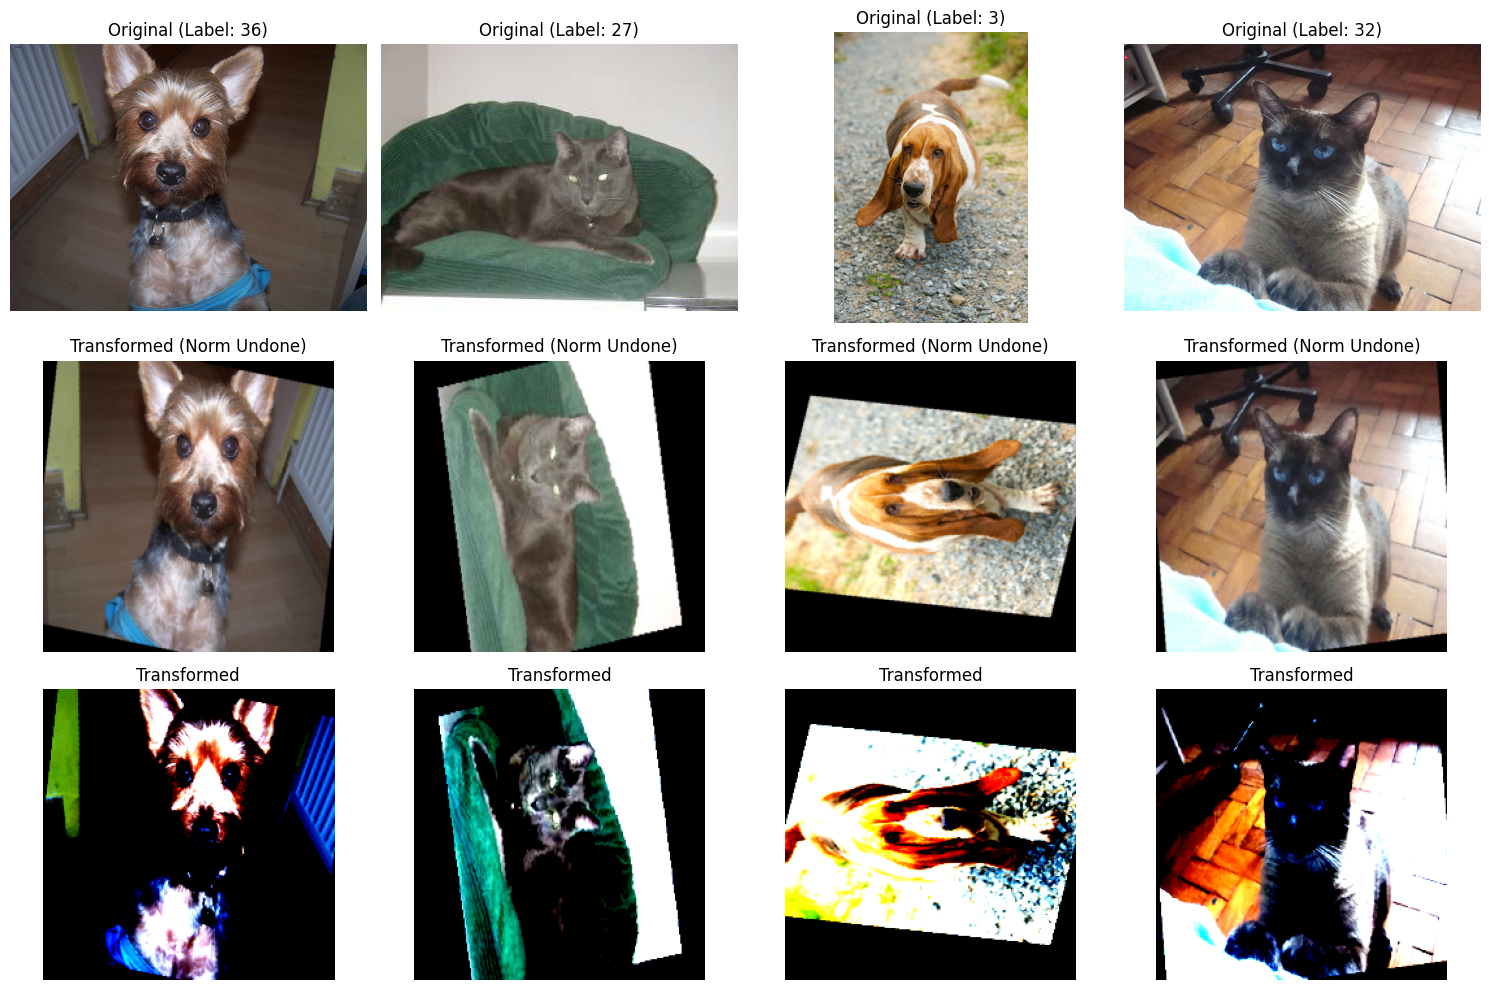

In [10]:
import matplotlib.pyplot as plt
import random

# Function to display images
def display_image_comparison(dataset, num_images=4):
    fig, axes = plt.subplots(3, num_images, figsize=(15, 10))  # 3 rows, num_images columns

    for i in range(num_images):
        # Randomly select an image from the dataset
        idx = random.randint(0, len(dataset) - 1)

        # Access the raw image without applying the dataset's transform
        img_path = dataset.root / "images" / f"{dataset.names[idx]}.jpg"
        original_img = Image.open(img_path).convert("RGB")  # Load as PIL image
        label = dataset.labels[idx]

        # Apply your transformation
        transformed_with_norm = transform_data_augmentation(original_img)  # Fully transformed with normalization

        # Undo normalization for visualization
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        transformed_with_norm_np = transformed_with_norm.permute(1, 2, 0).numpy()
        transformed_no_norm_np = std * transformed_with_norm_np + mean  # Undo normalization
        transformed_no_norm_np = transformed_no_norm_np.clip(0, 1)

        # Display original image
        axes[0, i].imshow(original_img)
        axes[0, i].set_title(f"Original (Label: {label})")
        axes[0, i].axis("off")

        # Display transformed image with normalization undone
        axes[1, i].imshow(transformed_no_norm_np)
        axes[1, i].set_title("Transformed (Norm Undone)")
        axes[1, i].axis("off")

        # Display fully transformed image (with normalization)
        axes[2, i].imshow(transformed_with_norm_np)
        axes[2, i].set_title("Transformed")
        axes[2, i].axis("off")

    plt.tight_layout()
    plt.show()

# Call the function to display the comparison
display_image_comparison(train_dataset, num_images=4)

In [11]:
import torch
import torchvision.models as models
import torch.nn as nn

# Load pretrained ResNet-18
pretrained_resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Adapt the final layer for 37 classes
num_classes = 37
pretrained_resnet.fc = nn.Linear(pretrained_resnet.fc.in_features, num_classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pretrained_resnet = pretrained_resnet.to(device)





AGGIUNTE DA QUI IN GIU'


Prepare the data 

In [12]:
train_dataset = OxfordPetDataset('train', transform=transform_data_augmentation)
val_dataset = OxfordPetDataset('val', transform=convert_compatible)
test_dataset = OxfordPetDataset('test', transform=convert_compatible)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
if False:
    #We define a training function reusing the function prev defined 
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(pretrained_resnet.parameters(), lr=0.001)

    train_losses, val_accuracies = train_model(
        pretrained_resnet, train_loader, val_loader,
        criterion, optimizer, num_epochs=60
    )


KeyboardInterrupt: 

Fine tune with previous hyper parameters

In [ ]:
lr = 0.001
batch_size = 32 
epochs = 60     # max


import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader

# Reuse your existing dataset and transforms from part 1
# Assuming: OxfordPetDataset, transform_data_augmentation, convert_compatible are already defined

# 1. Load pretrained ResNet-18 and modify the final FC layer
pretrained_resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
num_classes = 37
pretrained_resnet.fc = nn.Linear(pretrained_resnet.fc.in_features, num_classes)

# 2. Set device and move model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pretrained_resnet = pretrained_resnet.to(device)

# 3. Create Data Loaders
train_dataset = OxfordPetDataset('train', transform=transform_data_augmentation)
val_dataset = OxfordPetDataset('val', transform=convert_compatible)
test_dataset = OxfordPetDataset('test', transform=convert_compatible)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 4. Define Loss and Optimizer (same hyperparameters as part 1)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrained_resnet.parameters(), lr=0.001)

# 5. Define Training Loop (reuse function from part 1)
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc = 100 * correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Val Accuracy: {val_acc:.2f}%")

# 6. Train the model
train_model(pretrained_resnet, train_loader, val_loader, criterion, optimizer, num_epochs=60)
 
# 7. Evaluate on Test Set
pretrained_resnet.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = pretrained_resnet(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Final Test Accuracy (Part 2A): {100 * correct / total:.2f}%")





Epoch [1/60], Loss: 2.0281, Val Accuracy: 32.99%
Epoch [2/60], Loss: 1.4677, Val Accuracy: 45.58%
Epoch [3/60], Loss: 1.2681, Val Accuracy: 53.49%
Epoch [4/60], Loss: 1.0884, Val Accuracy: 49.40%
Epoch [5/60], Loss: 1.0196, Val Accuracy: 58.12%
Epoch [6/60], Loss: 0.9035, Val Accuracy: 52.24%
Epoch [7/60], Loss: 0.8112, Val Accuracy: 64.07%
Epoch [8/60], Loss: 0.7759, Val Accuracy: 51.91%
Epoch [9/60], Loss: 0.6942, Val Accuracy: 57.31%
Epoch [10/60], Loss: 0.7015, Val Accuracy: 58.94%
Epoch [11/60], Loss: 0.6808, Val Accuracy: 57.14%
Epoch [12/60], Loss: 0.5953, Val Accuracy: 62.76%
Epoch [13/60], Loss: 0.5636, Val Accuracy: 64.56%
Epoch [14/60], Loss: 0.5650, Val Accuracy: 62.43%
Epoch [15/60], Loss: 0.5572, Val Accuracy: 63.96%
Epoch [16/60], Loss: 0.4887, Val Accuracy: 65.65%
Epoch [17/60], Loss: 0.4688, Val Accuracy: 67.72%
Epoch [18/60], Loss: 0.4718, Val Accuracy: 61.89%
Epoch [19/60], Loss: 0.4113, Val Accuracy: 63.14%
Epoch [20/60], Loss: 0.3650, Val Accuracy: 68.05%
Epoch [21

In [ ]:
#DEPENDING ON ACCURACY RESULT PERHAPS WE SHOULD LOWER lr 

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
optimizer = torch.optim.Adam(pretrained_resnet.parameters(), lr=0.0001, weight_decay=1e-4)



Evaluation

In [ ]:
pretrained_resnet.eval()
correct = 0
total = 0

with torch.no_grad():
    for batch_images, batch_labels in test_loader:
        batch_images = batch_images.to(device)
        batch_labels = batch_labels.to(device)

        outputs = pretrained_resnet(batch_images)
        _, predicted = torch.max(outputs.data, 1)

        total += batch_labels.size(0)
        correct += (predicted == batch_labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")
